In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import *
from pid import PID_ControllerClass
np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Done.
Ready.


##### parse `UR5e`

In [2]:
env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/UR5_rg2_gripper.xml')
print ("[%s] parsed."%(env.name))

[UR5e] parsed.


In [3]:
PID = PID_ControllerClass(
    name = 'PID', dim = env.n_robot_joint,
    k_p = 1000.0, k_i = 0.0, k_d = 100.0, # <= D gain is super important
    out_min = env.torque_range[env.n_joint_idxs,0],
    out_max = env.torque_range[env.n_joint_idxs,1],
    ANTIWU  = True)
print ("Done.")

Done.


##### Get camera informations

In [4]:
# Get camera information
cam_infos = env.set_cam_infos(cam_distance  = 0.0,
                    cam_azimuth   = 0.0,
                    cam_elevation = -90.0,
                    cam_lookat    = [1.0,0.0,3.0])

cam_infos

{'cam_distance': 0.0,
 'cam_azimuth': 0.0,
 'cam_elevation': -90.0,
 'cam_lookat': array([1., 0., 3.])}

##### `PID` control

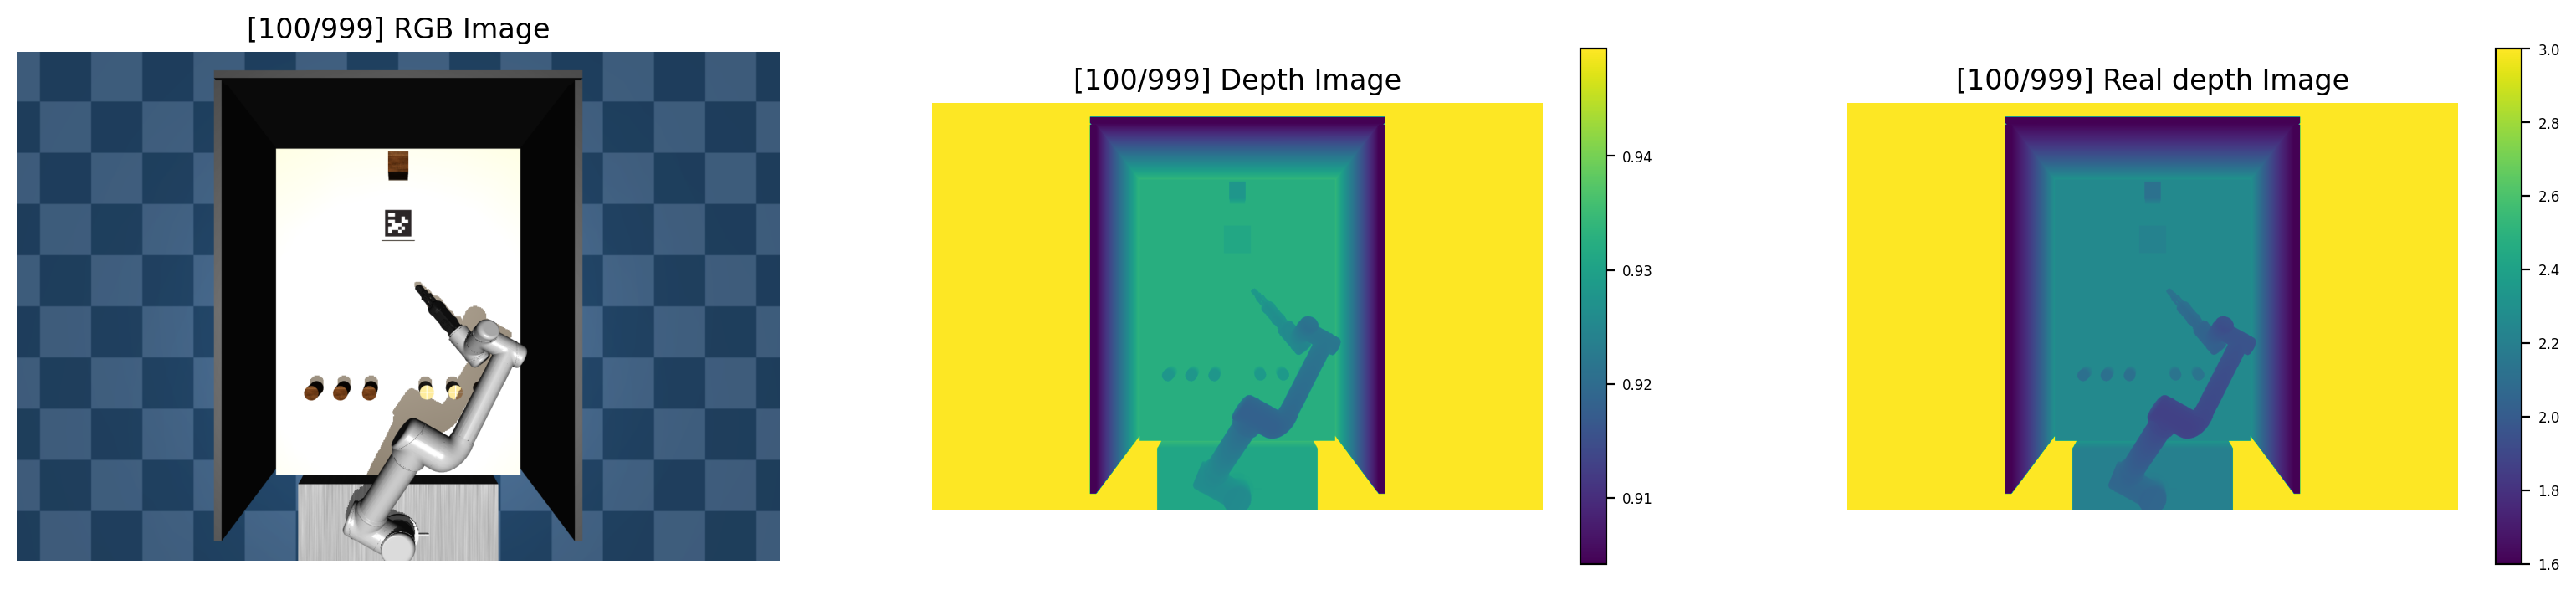

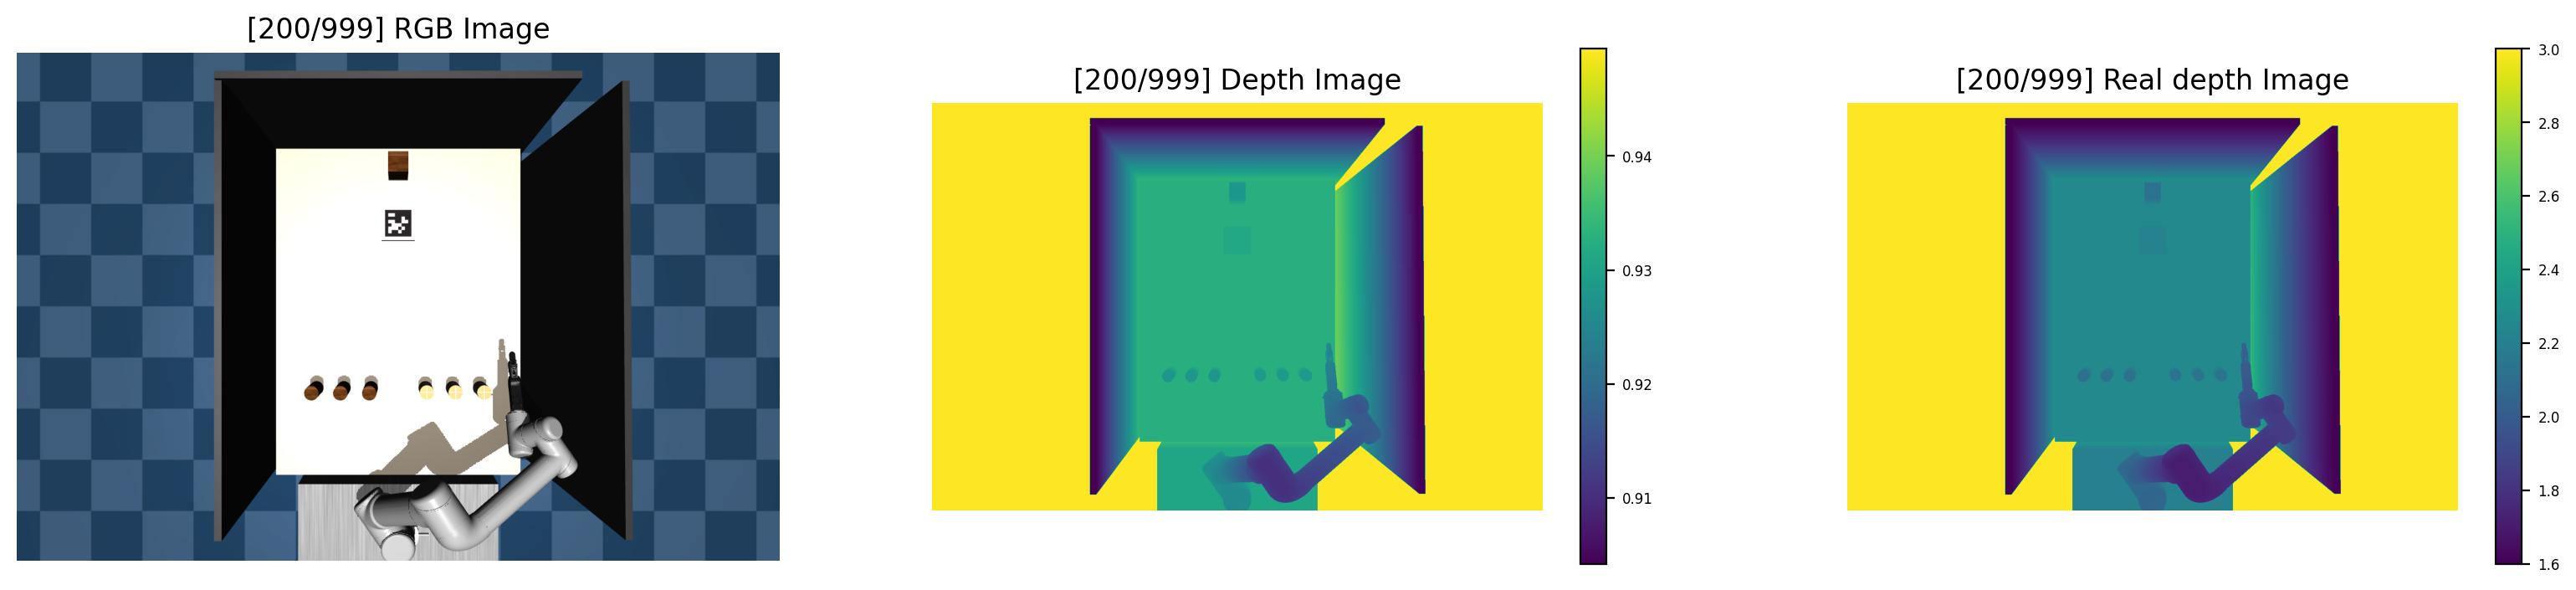

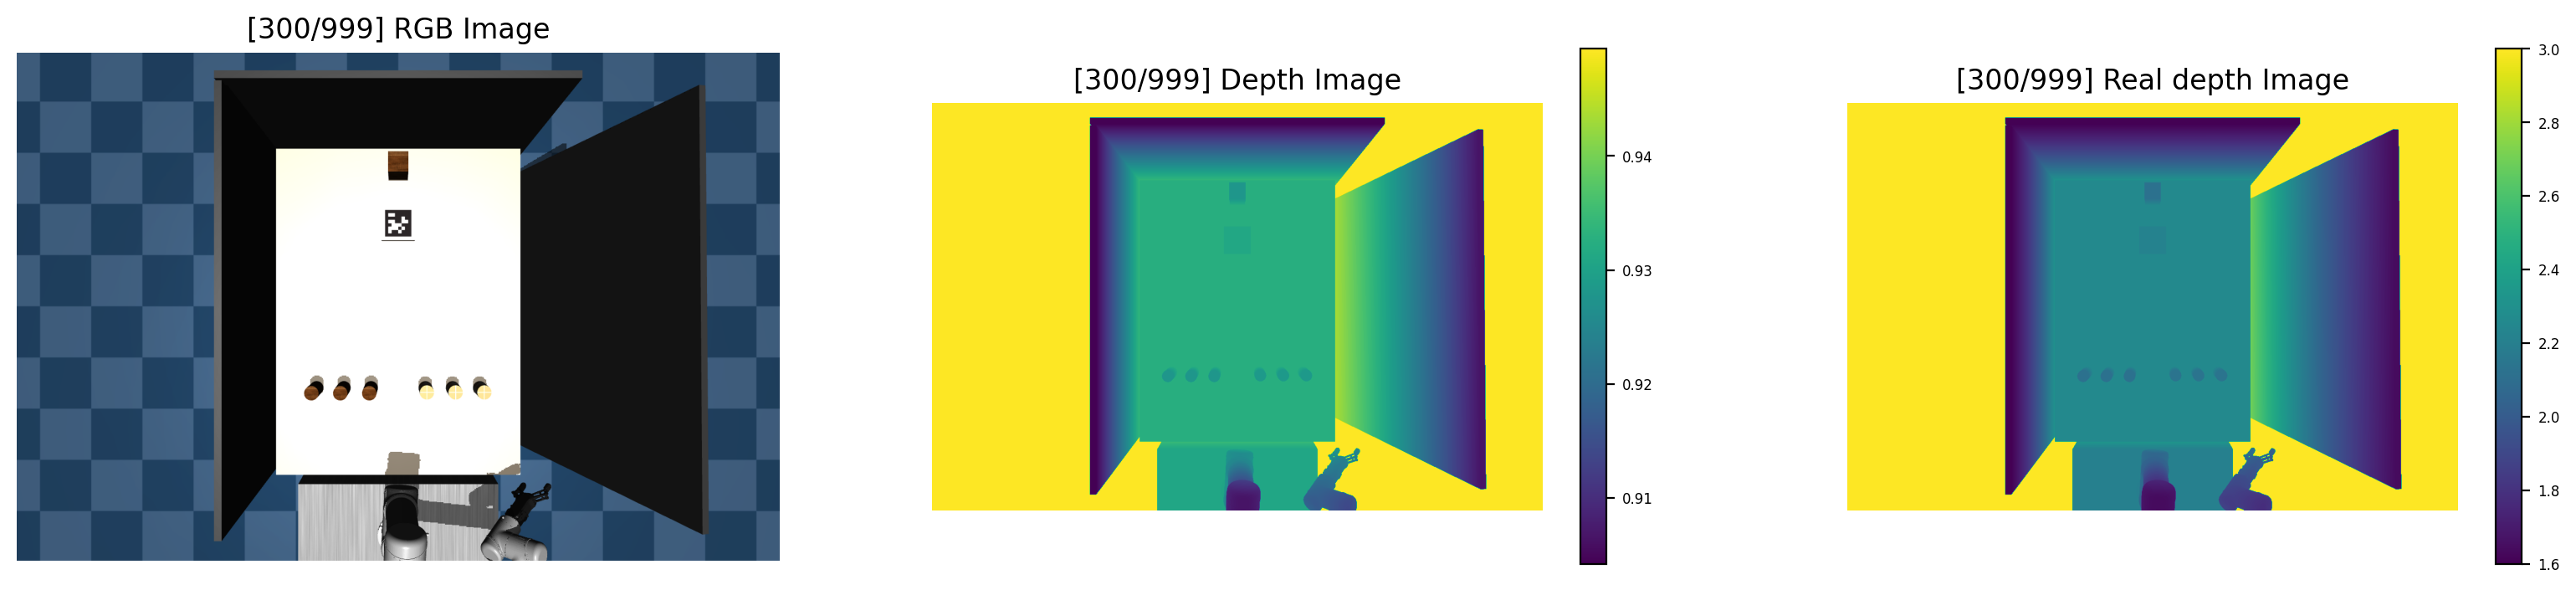

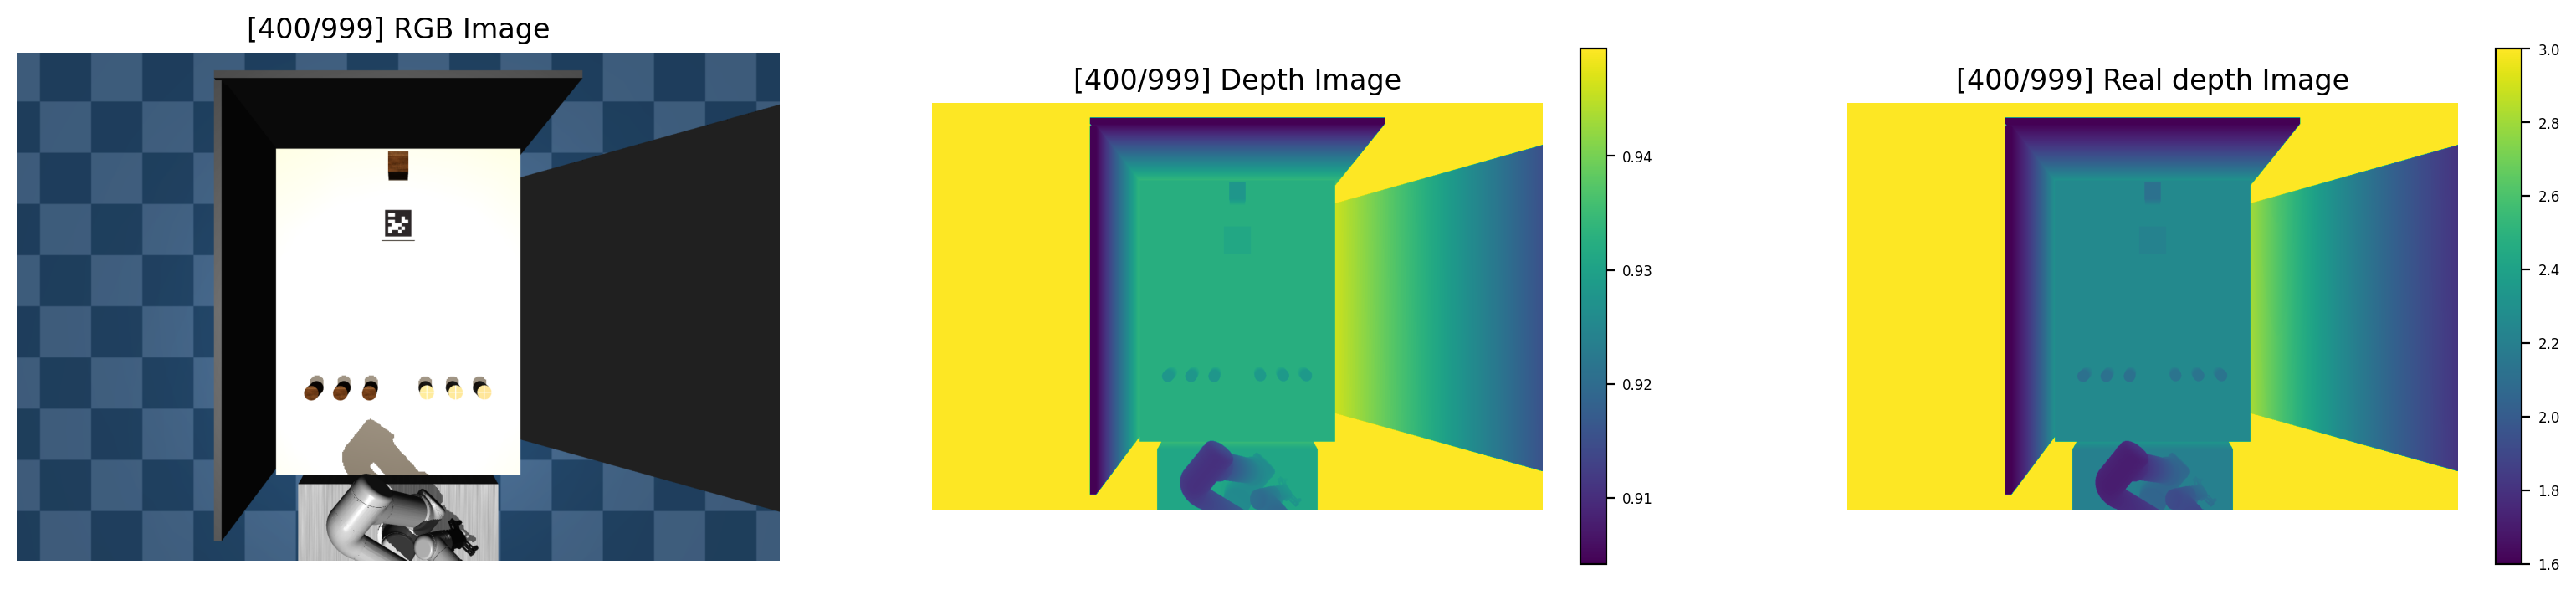

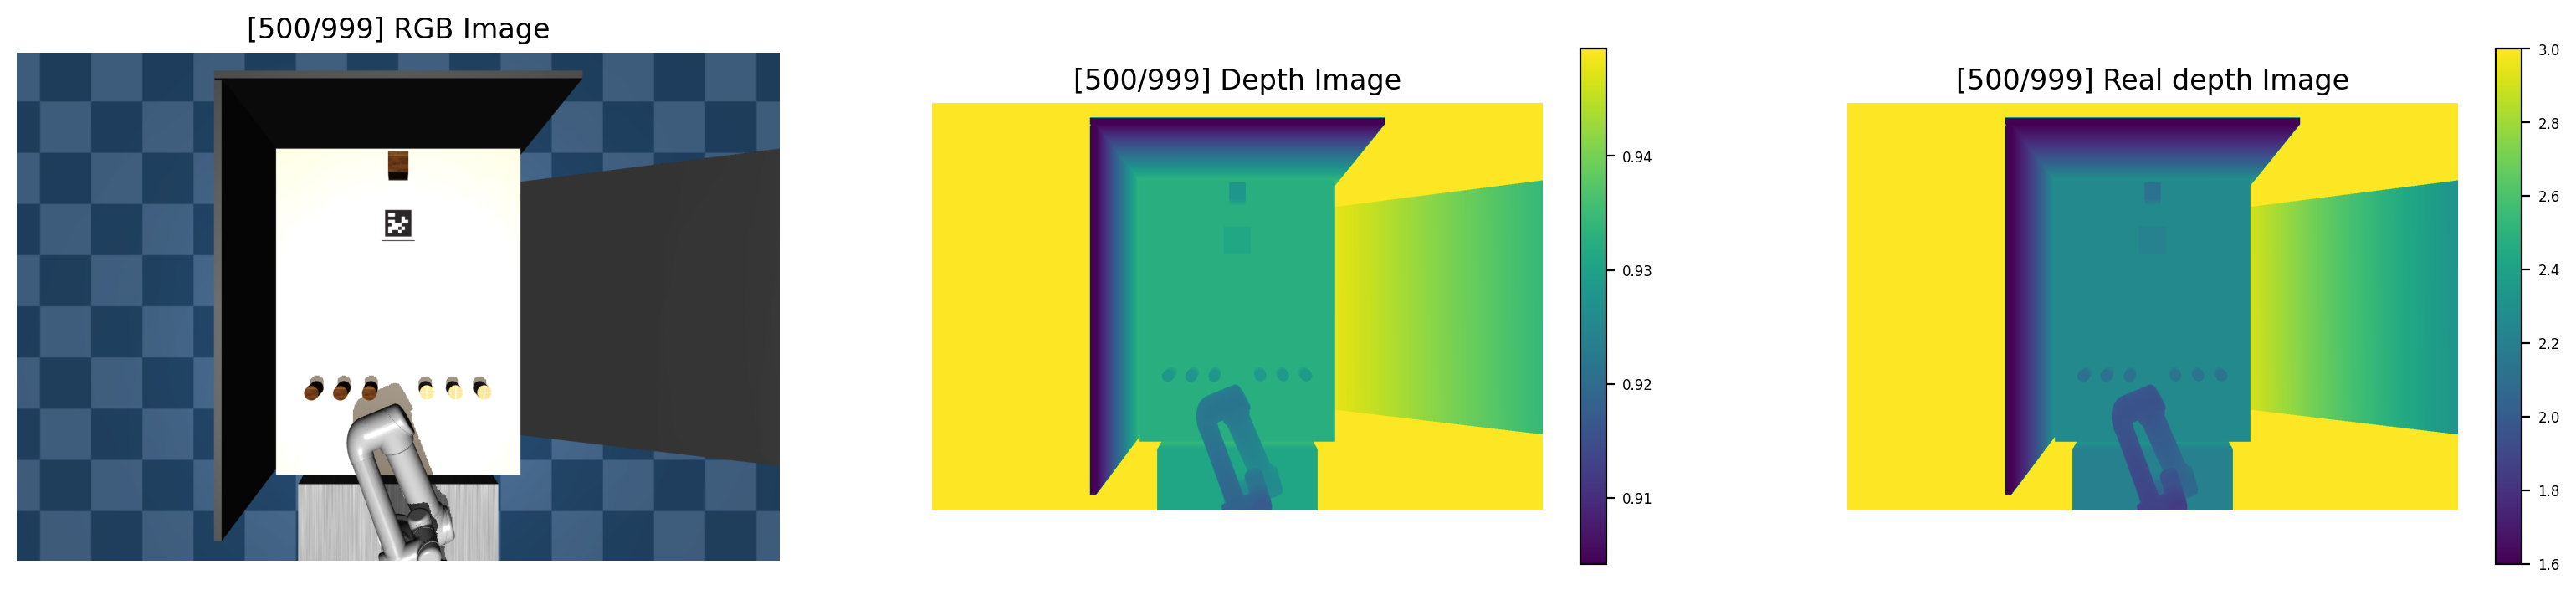

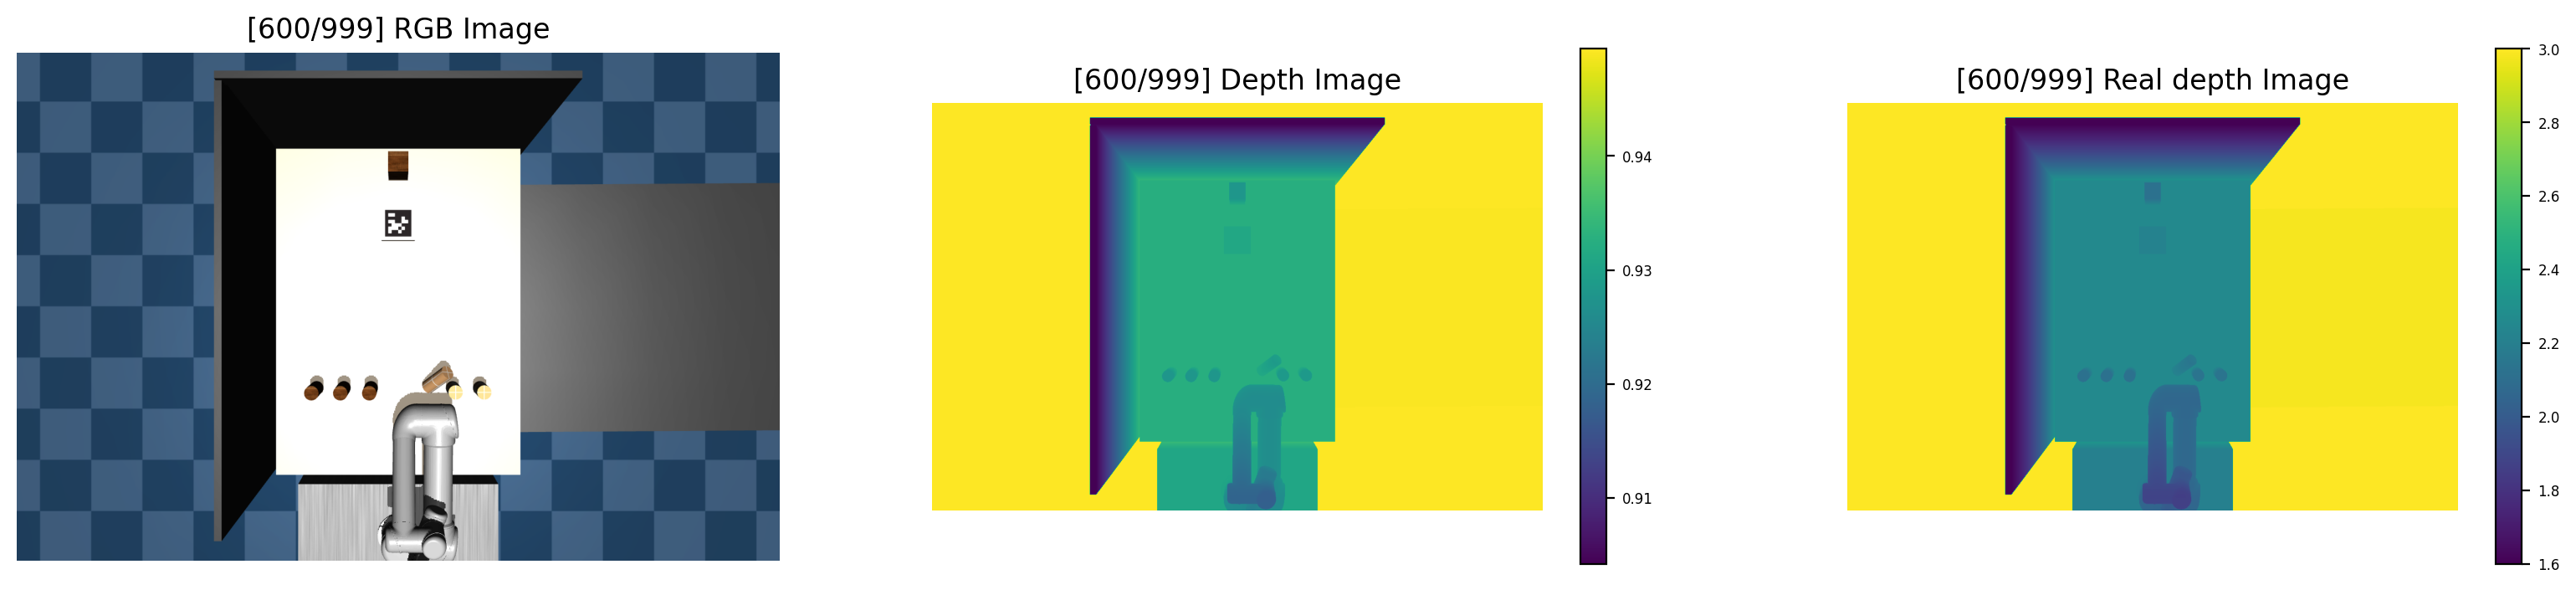

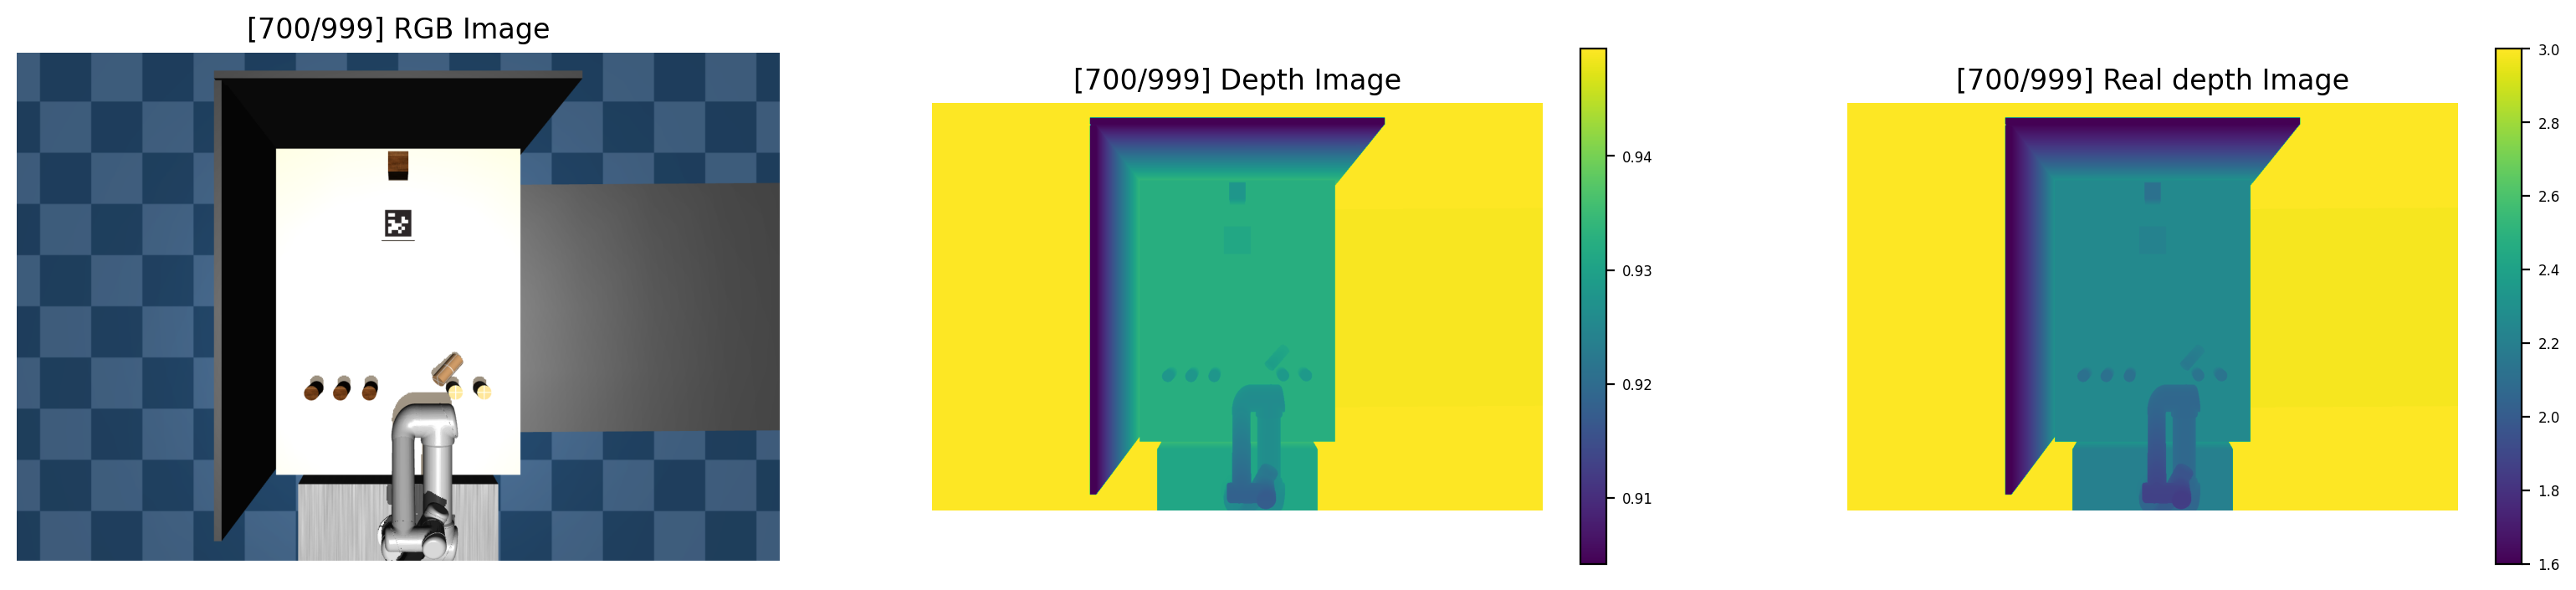

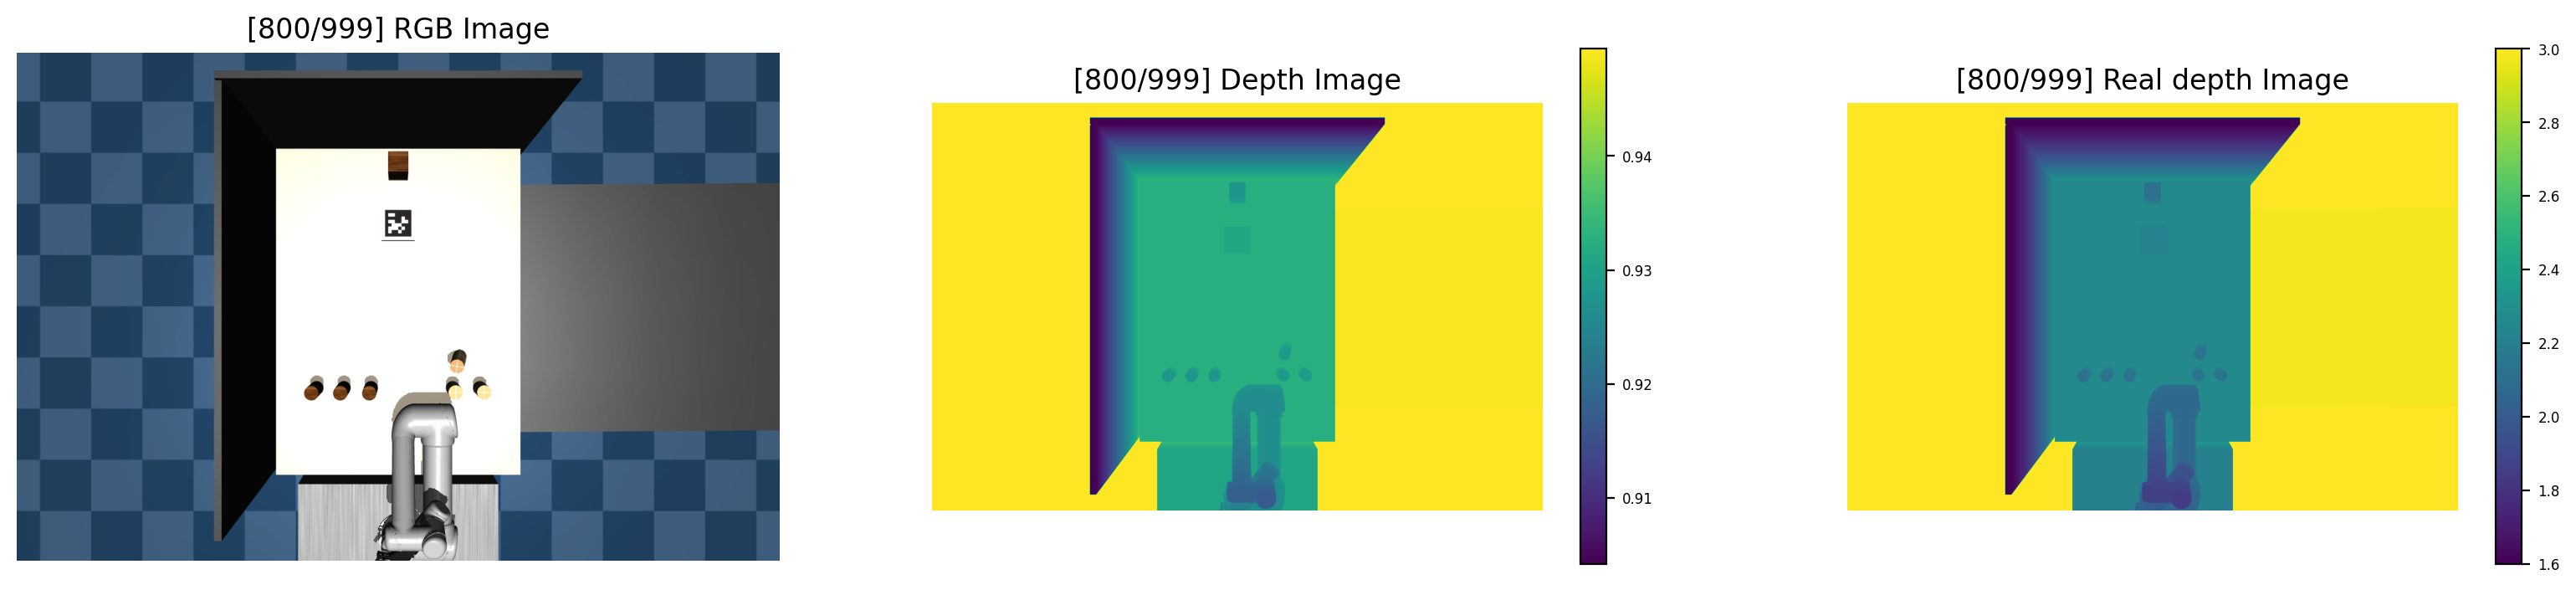

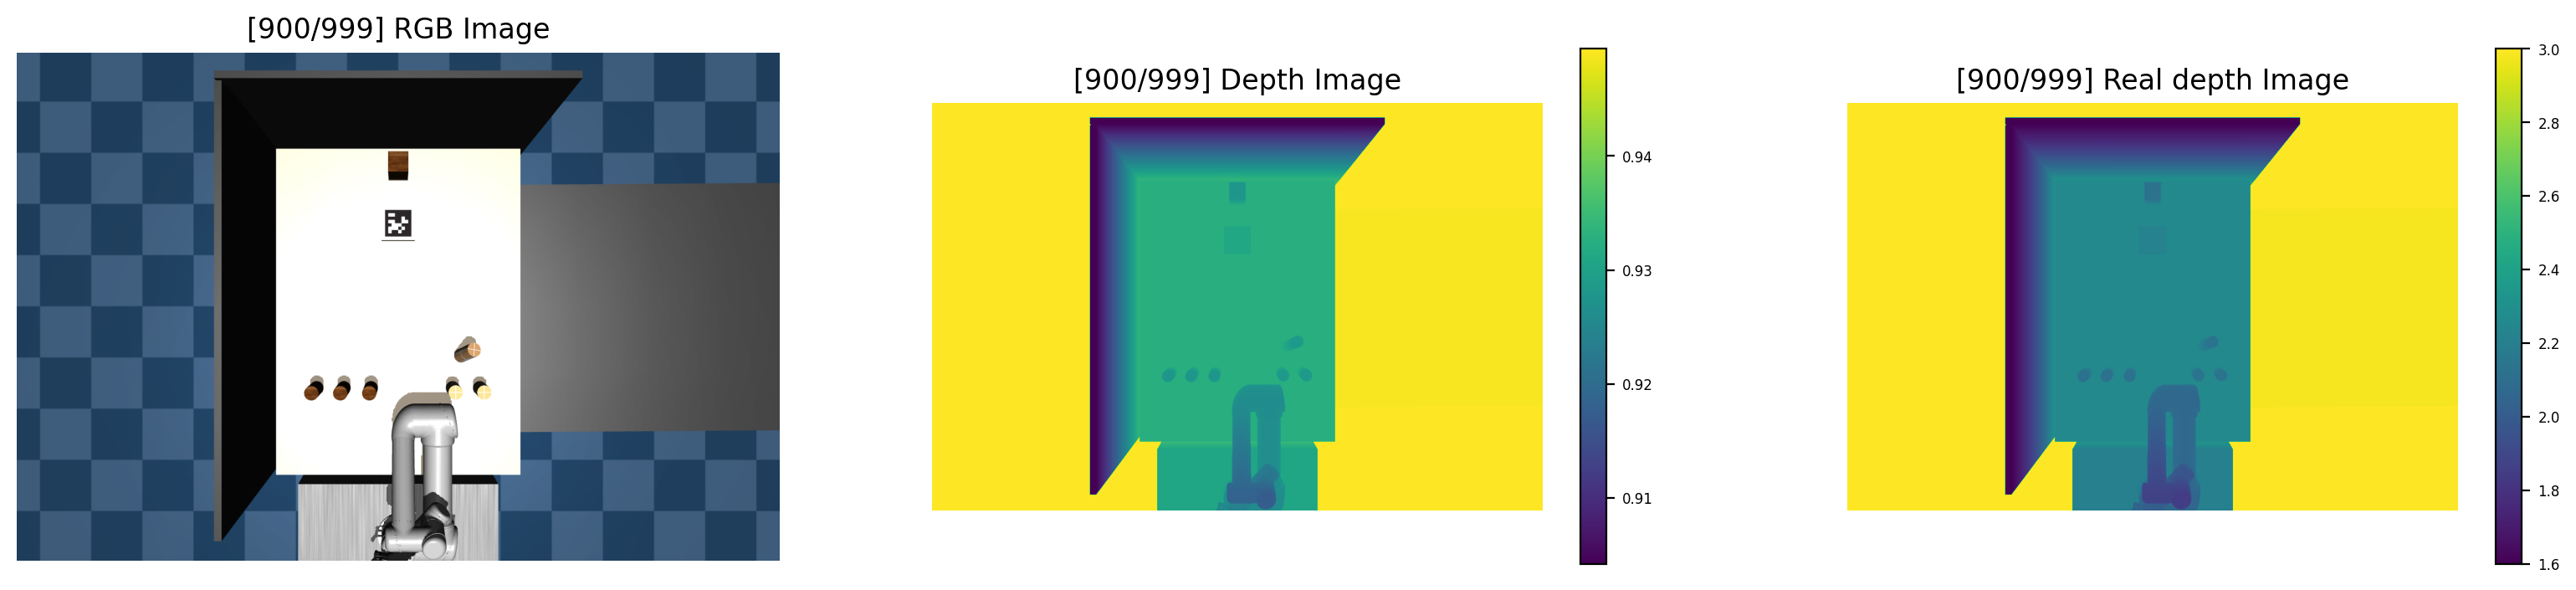

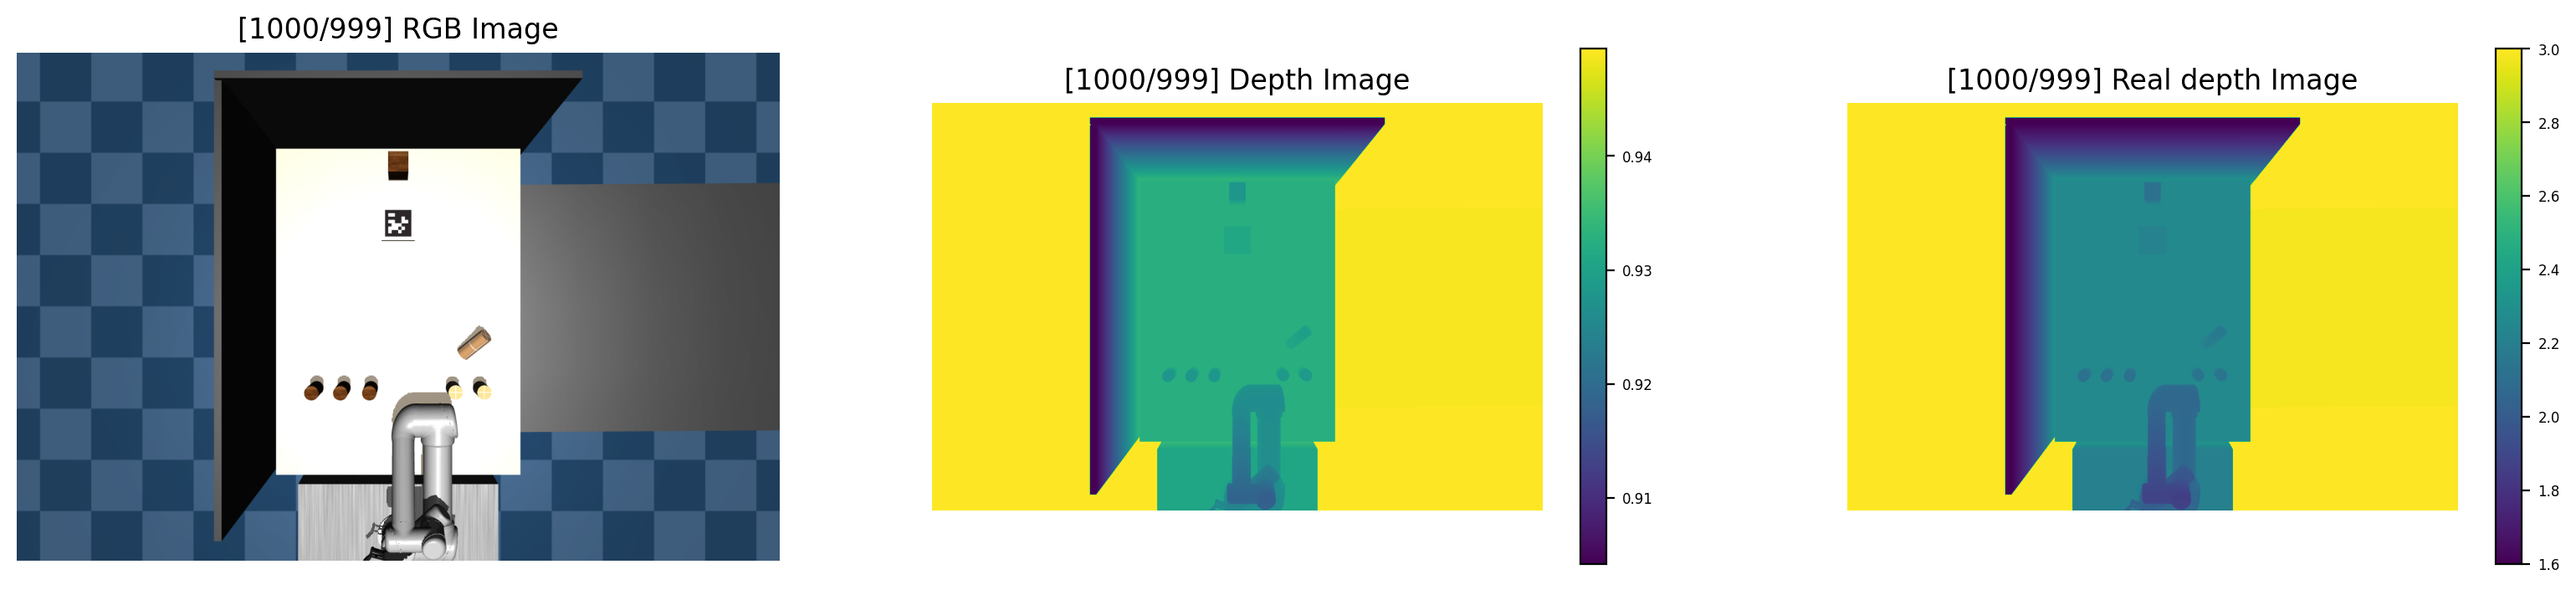

Done.


In [5]:
env.reset()
PID.reset()

# Desired position target for PID control
q_des1 = np.array([-90, -135, 135, 90, 45, 90, 0])*np.pi/180.0
q_des2 = np.array([-90, -135, 135, 90, 45, 90, 0])*np.pi/180.0
q_des3 = np.array([-90, -135, 135, 90, 45, 90, 0])*np.pi/180.0

# Buffers
max_tick    = 1000
sec_list    = np.zeros(shape=max_tick)
q_list      = np.zeros(shape=(max_tick,env.n_robot_joint))
q_des_list  = np.zeros(shape=(max_tick,PID.dim))
torque_list = np.zeros(shape=(max_tick,env.n_robot_joint))

while env.tick < max_tick:
    if (env.tick/max_tick) < 1/3: q_des = q_des1
    elif (env.tick/max_tick) < 2/3: q_des = q_des2
    else: q_des = q_des3

    # PID control
    PID.update(x_trgt=q_des)
    PID.update(t_curr=env.get_sim_time(),x_curr=env.get_q_pos(q_pos_idxs=env.n_joint_idxs),VERBOSE=False)
    torque = PID.out()

    env.step(ctrl=torque, ctrl_idxs=env.n_joint_idxs)
    # env.render()
    env.forward(INCREASE_TICK=False)

    if env.tick%100 == 0:

        for _ in range(2):
            img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
            img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=True, camera_name="track")
            img_real = np.array(env.depth_2_meters(img_depth))

        plt.figure(figsize=(20,4))
        plt.subplot(1, 3, 1)
        plt.imshow(img); plt.axis('off')
        # plt.title("RGB Image")
        plt.title('[%d/%d] RGB Image'%(env.tick,max_tick-1))
        # plt.show()

        plt.subplot(1, 3, 2)
        plt.imshow(img_depth); plt.axis('off')
        # plt.title("Depth Image")
        plt.title('[%d/%d] Depth Image'%(env.tick,max_tick-1))
        plt.colorbar()
        # plt.show()

        plt.subplot(1, 3, 3)
        plt.imshow(img_real); plt.axis('off')
        # plt.title("Real depth Image")
        plt.title('[%d/%d] Real depth Image'%(env.tick,max_tick-1))
        plt.colorbar()
        plt.show()

    # Append
    sec_list[env.tick-1]      = env.get_sim_time()
    q_list[env.tick-1,:]      = env.get_q_pos(q_pos_idxs=env.n_joint_idxs)
    q_des_list[env.tick-1,:]  = q_des
    torque_list[env.tick-1,:] = torque

print ("Done.")

/tmp/ipykernel_9709/610009306.py:9: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(bottom=env.joint_range[a_idx,0]-qmarg,top=env.joint_range[a_idx,1]+qmarg)


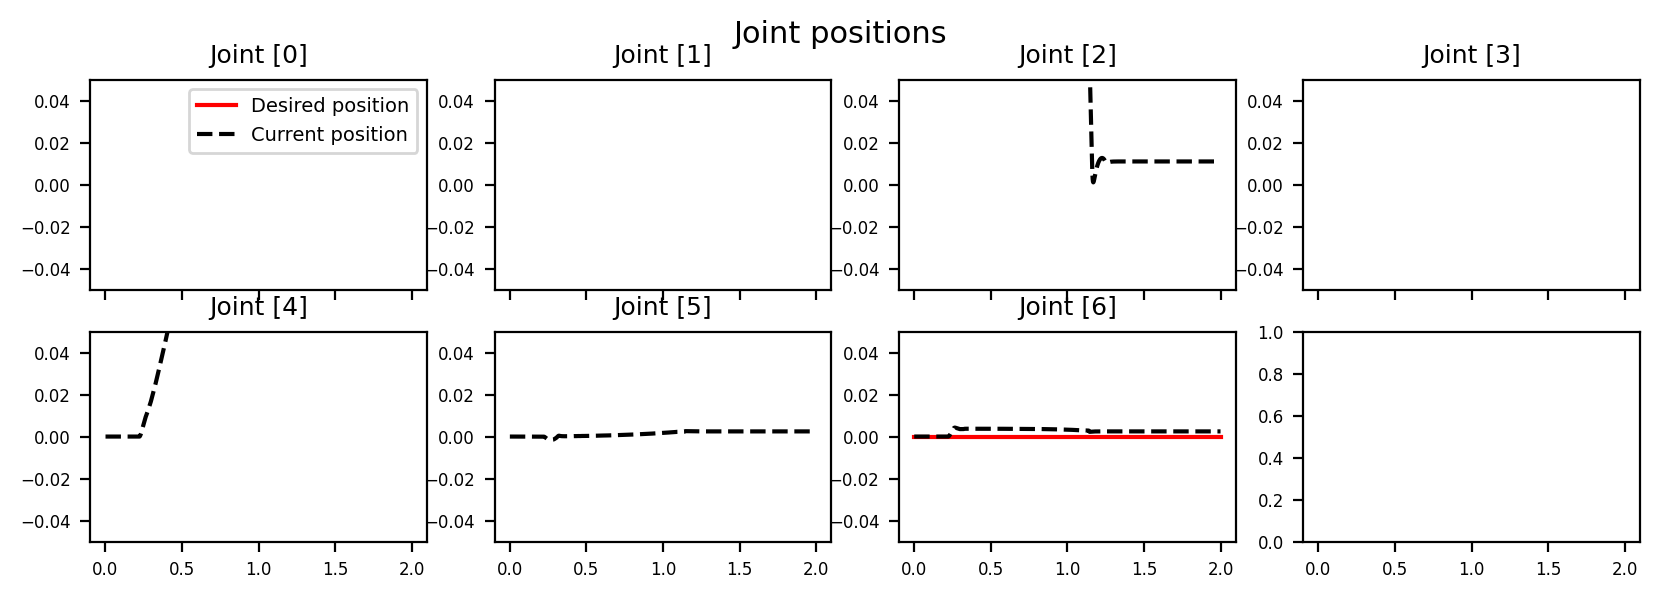

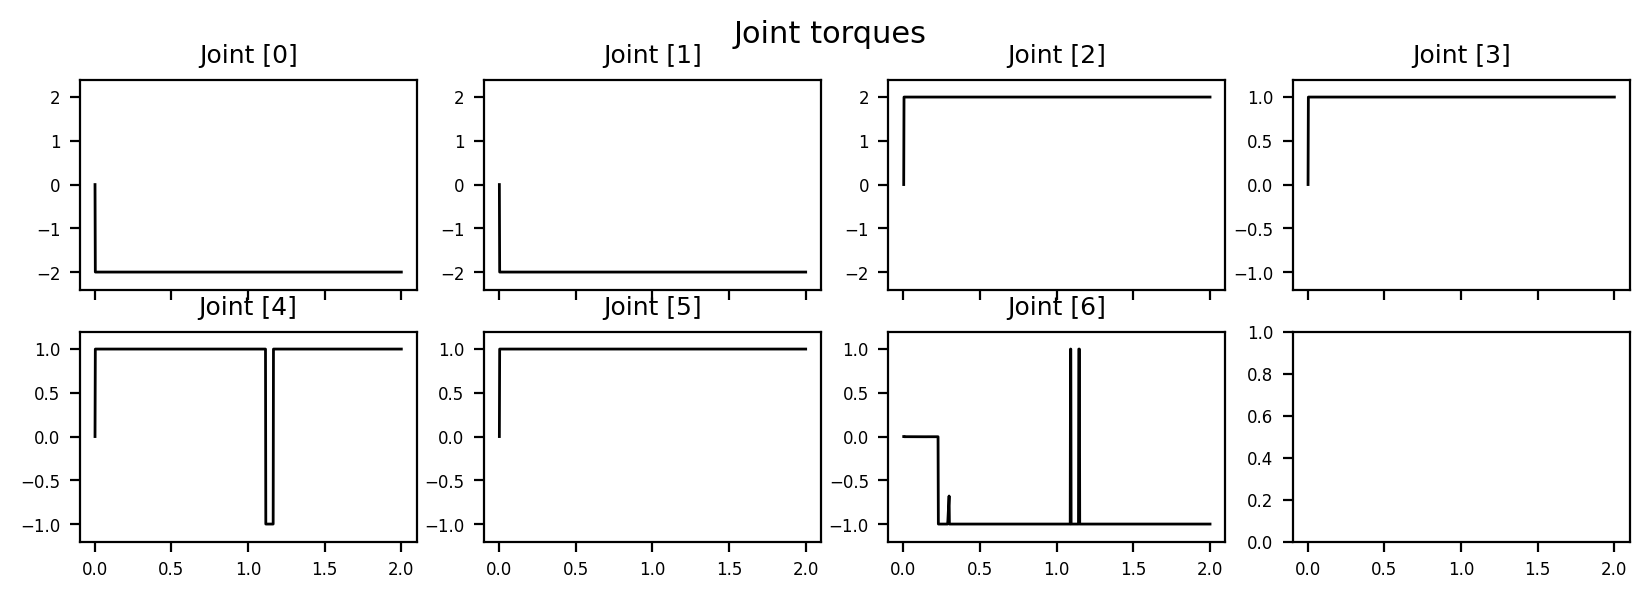

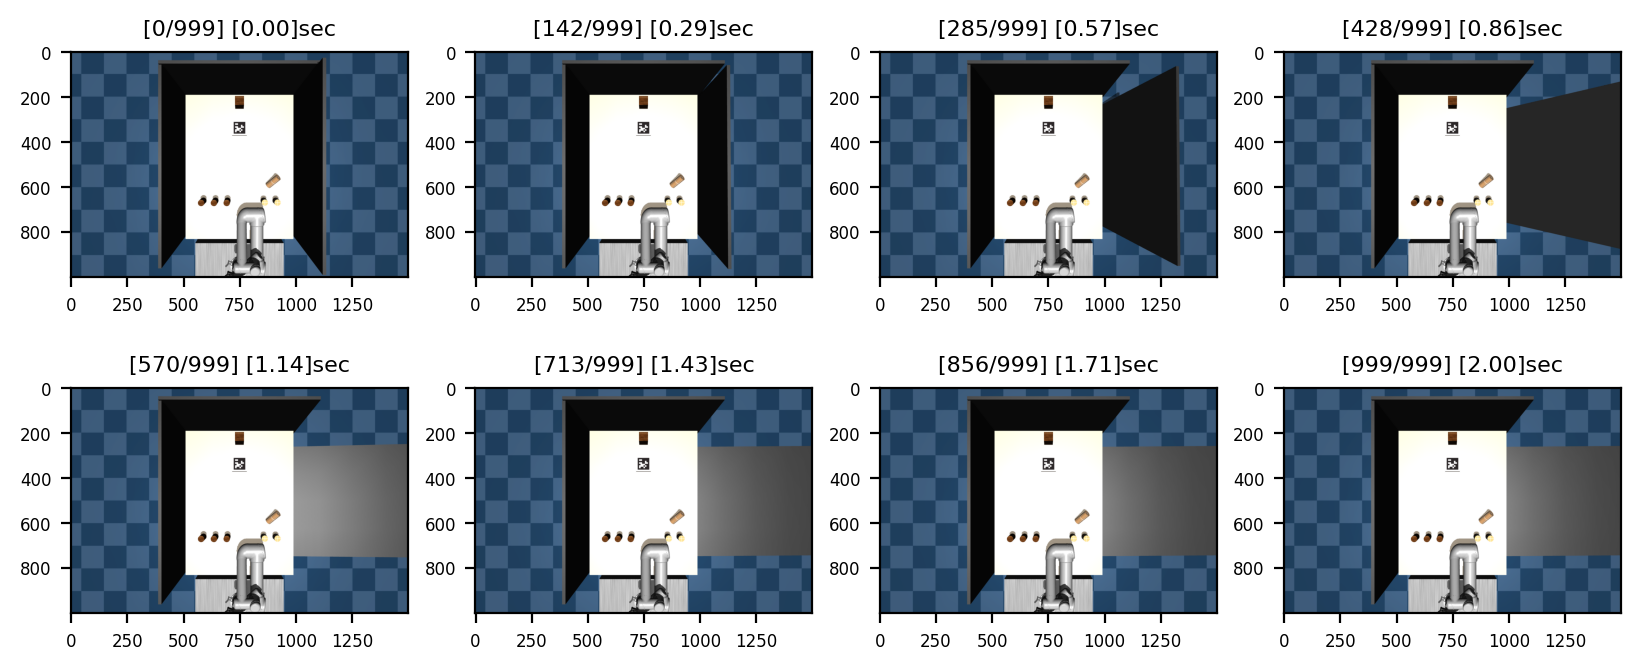

In [6]:
# Plot joint positions
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(10,3))
fig.suptitle("Joint positions", fontsize=11)
for a_idx,ax in enumerate(axs.ravel()):
    if (a_idx >= PID.dim): continue
    ax.plot(sec_list,q_des_list[:,a_idx],'-',color='r',label='Desired position')
    ax.plot(sec_list,q_list[:,a_idx],'--',color='k',label='Current position')
    qmarg = 0.1*(env.joint_range[a_idx,1]-env.joint_range[a_idx,0])
    ax.set_ylim(bottom=env.joint_range[a_idx,0]-qmarg,top=env.joint_range[a_idx,1]+qmarg)
    ax.set_title('Joint [%d]'%(a_idx),fontsize=9)
    if a_idx == 0: ax.legend(fontsize=7)
plt.show()
# Plot joint torques
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(10,3))
fig.suptitle("Joint torques", fontsize=11)
for a_idx,ax in enumerate(axs.ravel()):
    if (a_idx >= PID.dim): continue
    ax.plot(sec_list,torque_list[:,a_idx],'-',color='k',label='',lw=1)
    tmarg = 0.1*(env.torque_range[a_idx,1]-env.torque_range[a_idx,0])
    ax.set_ylim(bottom=env.torque_range[a_idx,0]-tmarg,top=env.torque_range[a_idx,1]+tmarg)
    ax.set_title('Joint [%d]'%(a_idx),fontsize=9)
plt.show()
# Plot snapshots for Panda with FK
fig = plt.figure(figsize=(10,4))
for idx,tick in enumerate(np.linspace(0,max_tick-1,8).astype(np.int32)):
    env.forward(q_pos=q_list[tick,:],q_pos_idxs=env.n_joint_idxs)
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
    # img = env.plot_scene(RETURN_IMG=True)
    ax = fig.add_subplot(2,4,idx+1)
    ax.imshow(img)
    ax.set_title('[%d/%d] [%.2f]sec'%(tick,max_tick-1,sec_list[tick]),fontsize=8)

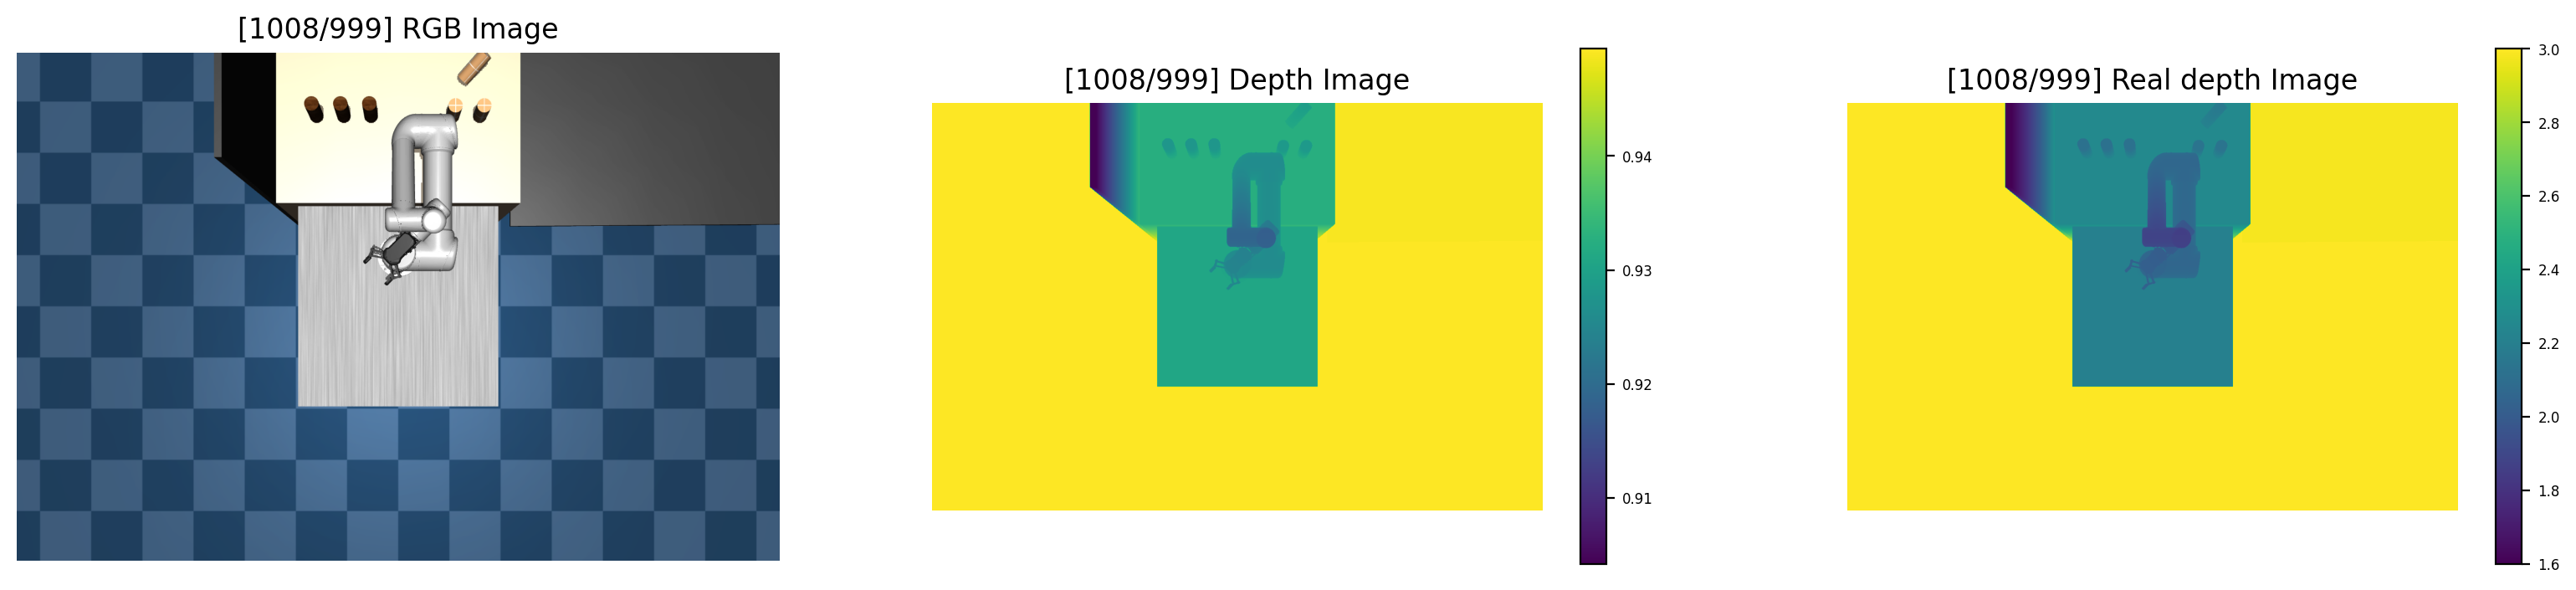

In [9]:
# Get camera information
cam_infos = env.set_cam_infos(cam_distance  = 0.0,
                    cam_azimuth   = 0.0,
                    cam_elevation = -90.0,
                    cam_lookat    = [0.0,0.0,3.0])

for _ in range(2):
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
    img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=True, camera_name="track")
    img_real = np.array(env.depth_2_meters(img_depth))

plt.figure(figsize=(20,4))
plt.subplot(1, 3, 1)
plt.imshow(img); plt.axis('off')
# plt.title("RGB Image")
plt.title('[%d/%d] RGB Image'%(env.tick,max_tick-1))
# plt.show()

plt.subplot(1, 3, 2)
plt.imshow(img_depth); plt.axis('off')
# plt.title("Depth Image")
plt.title('[%d/%d] Depth Image'%(env.tick,max_tick-1))
plt.colorbar()
# plt.show()

plt.subplot(1, 3, 3)
plt.imshow(img_real); plt.axis('off')
# plt.title("Real depth Image")
plt.title('[%d/%d] Real depth Image'%(env.tick,max_tick-1))
plt.colorbar()
plt.show()